# St Ebbes reference data work flow to support aggregations by COVID restriction data

## Imports

In [1]:
# Imports
#---------
import pandas as pd
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import statsmodels.api as sm

aurn_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/aurn_2016_2021/'
stats_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/gap_filling/536_method/lockdown_stats/'


## Load reference data
1-hour reference data for Oxford AURN & AQE stations obtained from Ricardo R data store. See also;

`/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/data_for_ajit/get_1hour_ox_auto_data.ipynb`

Using 6-years data 2016 to 2021 to estimate average conditions over this period. Reasoning for 6 years being, 2016 had low data capture & 2021 forms part of the study year.

Index(['OX', 'OX8', 'OX3', 'OX6'], dtype='object', name='code')

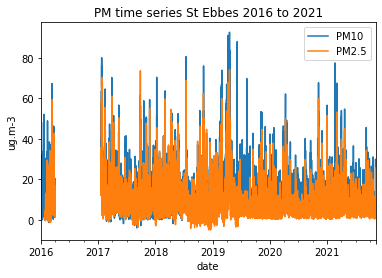

In [2]:
# Load 1-hour data 2016 to 2021
#-------------------------------

oxford_auto_20162021_1hr = pd.read_csv(aurn_home+'oxford_auto_20162021_1hr.csv.gz')#, index_col='date')
oxford_auto_20162021_1hr['date'] = pd.to_datetime(oxford_auto_20162021_1hr['date'], utc=True)
oxford_auto_20162021_1hr.set_index(['date','code','site'], inplace=True)
display(oxford_auto_20162021_1hr.index.get_level_values(1).unique())

oxford_auto_20162021_1hr.query('code == "OX8"').sort_index().reset_index().plot(x='date', 
                                                                                y=['PM10','PM2.5'], 
                                                                                title='PM time series St Ebbes 2016 to 2021',
                                                                                ylabel='ug.m-3')
plt.show()

## Reorganising the dataframe & aggregating
1-hour data reduced to St Ebbes & O2, PM10 & PM2.5 only. Data then grouped by the day of year, binning all 1-hour data across 6 years togther by ordinal day, then calculating descriptive statistics on these binned data. Key descriptive stats being the mean (of 1-hour observations) each day (daily mean) & the 95th percentile of hourly means each day.

These stats provide an indicator of the variation in typical & extreme concentrations influenced local conditions each day throughout the pandemic. In a later step we group & aggregate these descriptive stats further by restriction event to show temporal variations that will be influenced by the event(s) & meterologocal conditions.

In [3]:
# Housekeeping & aggregation
#-----------------------------
start16 = pd.to_datetime('2016-01-01', utc=True)
end19 = pd.to_datetime('2020-01-01', utc=True)

# Constrained to sebbes only
sebbes1619 = oxford_auto_20162021_1hr.query('code == "OX8" and @start16 <= date < @end19')
# Constrain to no2, pm10
sebbes = sebbes1619[['PM2.5','PM10']].reset_index(['code','site']) #.resample('1D', closed = 'right').mean() 
# aggregate by ordinal day
sebbes_ordinal_daymean = sebbes.groupby(sebbes.index.dayofyear).describe(percentiles=[0.90, 0.95])
sebbes_ordinal_daymean

PM2.5                                                               PM10  \
     count       mean       std  min      50%      90%      95%     max count   
date                                                                            
1     47.0   4.642553  2.464949  0.5   4.4000   8.3000   9.2200  10.000  48.0   
2     42.0   5.450000  3.815389 -2.9   4.8500   9.2800  10.4650  17.100  48.0   
3     12.0   3.708333  2.325143  0.1   3.2000   6.4900   7.0400   7.700  36.0   
4      0.0        NaN       NaN  NaN      NaN      NaN      NaN     NaN  23.0   
5     11.0   9.736364  7.576975  1.1   6.0000  19.9000  20.0000  20.100  12.0   
...    ...        ...       ...  ...      ...      ...      ...     ...   ...   
362   54.0  13.098630  6.715243  0.1  11.1000  21.5500  24.3350  34.800  72.0   
363   68.0   8.667926  4.658593 -0.9   9.0135  15.4907  17.5237  18.600  72.0   
364   70.0  10.663543  5.930981 -0.7  10.9600  18.0166  21.5750  32.300  72.0   
365   69.0   8.852420  7.028753 -1.0   7.5000  18.8352  20.4906  26.651  72.0   
366    0.0        NaN       NaN  NaN      NaN      NaN      NaN     NaN   0.0   

                                                                     
           mean        std  min      50%      90%       95%     max  
date                                                                 
1      7.918750   3.466782  1.4   7.1500  12.7100  15.41500  16.000  
2     11.727083   8.469890  0.0   9.3500  20.8800  32.76000  39.000  
3     14.255556  10.552060  0.5  12.5000  28.7000  31.82500  34.300  
4     10.217391   8.269915  1.5   6.4000  23.3200  28.59000  29.300  
5      7.666667   3.576523  3.3   7.4000  10.8500  12.70000  14.900  
...         ...        ...  ...      ...      ...       ...     ...  
362   12.872569   7.567904  2.7  10.0000  24.6700  26.73500  30.000  
363   10.955903   4.905644  1.1  11.2875  17.0975  19.17125  24.500  
364   15.638542   9.097126  1.0  13.5125  28.1900  32.86000  36.500  
365   11.084722   7.209489 -0.4   9.8750  22.1950  22.63375  28.975  
366         NaN        NaN  NaN      NaN      NaN       NaN     NaN  

[366 rows x 16 columns]

In [4]:
# Sort index
s1 = sebbes_ordinal_daymean.iloc[:,[0,1,2,3,4,5,6,7]].add_prefix('pm25_').columns.droplevel()
s2 = sebbes_ordinal_daymean.iloc[:,[8,9,10,11,12,13,14,15]].add_prefix('pm10_').columns.droplevel()

new_cols = list(s1.append([s2]))
sebbes_ordinal_daymean.columns = new_cols

sebbes_ordinal_daymean

,pm25_count,pm25_mean,pm25_std,pm25_min,pm25_50%,pm25_90%,pm25_95%,pm25_max,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_50%,pm10_90%,pm10_95%,pm10_max
date,,,,,,,,,,,,,,,,
1,47.0,4.642553,2.464949,0.5,4.4000,8.3000,9.2200,10.000,48.0,7.918750,3.466782,1.4,7.1500,12.7100,15.41500,16.000
2,42.0,5.450000,3.815389,-2.9,4.8500,9.2800,10.4650,17.100,48.0,11.727083,8.469890,0.0,9.3500,20.8800,32.76000,39.000
3,12.0,3.708333,2.325143,0.1,3.2000,6.4900,7.0400,7.700,36.0,14.255556,10.552060,0.5,12.5000,28.7000,31.82500,34.300
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,10.217391,8.269915,1.5,6.4000,23.3200,28.59000,29.300
5,11.0,9.736364,7.576975,1.1,6.0000,19.9000,20.0000,20.100,12.0,7.666667,3.576523,3.3,7.4000,10.8500,12.70000,14.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,54.0,13.098630,6.715243,0.1,11.1000,21.5500,24.3350,34.800,72.0,12.872569,7.567904,2.7,10.0000,24.6700,26.73500,30.000
363,68.0,8.667926,4.658593,-0.9,9.0135,15.4907,17.5237,18.600,72.0,10.955903,4.905644,1.1,11.2875,17.0975,19.17125,24.500
364,70.0,10.663543,5.930981,-0.7,10.9600,18.0166,21.5750,32.300,72.0,15.638542,9.097126,1.0,13.5125,28.1900,32.86000,36.500


## Choosing metrics to demonstrate change
The graphs below demonstrate the pros & cons of 3 methods / metrics that could be used to demonstrate deviation from typical levels already experienced 2016-2021. Using the standard daily mean is shown to be potentially problematic because of the variation in the statistic throughout the year. As alternative we present 2 different initialisations LOWESS regression smoothing method which applies Locally Weighted Scatterplot Smoothing to smooth the peak in the standard daily mean, plus a rolling 28-day mean.

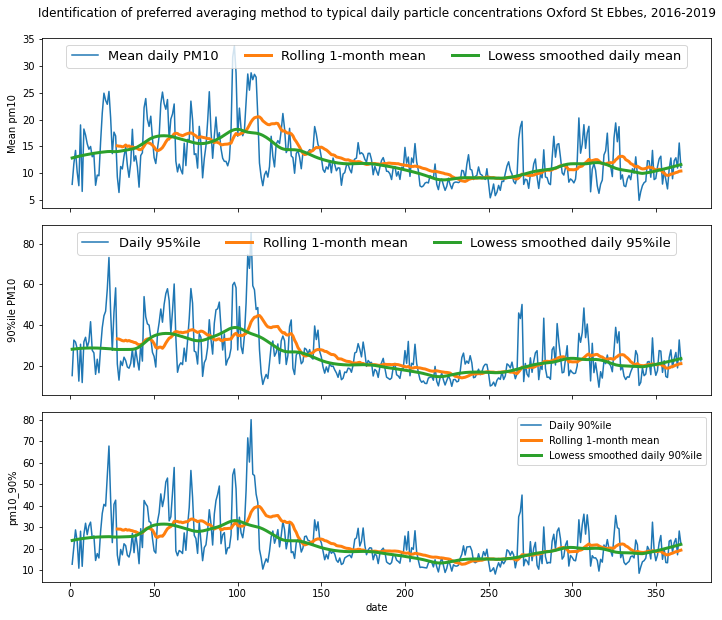

In [5]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

# Doing PM10
#------------
figure, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), 
             x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess
                           (exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_mean'], frac=0.13, it=1),  columns=['x','y10'])

sns.lineplot(data=smoothed_m2, x='x', y='y10', ax=ax1, label='Lowess smoothed daily mean', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_95%'], frac=0.13, it=1),  columns=['x','ypm1095'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm1095', ax=ax2, label='Lowess smoothed daily 95%ile', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])


ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford High St, 2016-2019\n')
ax2.set(ylabel = '95%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Daily 90%ile', lw=1.5)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28).mean(), x=sebbes_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Rolling 1-month mean', lw=3)

smoothed_m2 = pd.DataFrame(sm.nonparametric.lowess(exog=sebbes_ordinal_daymean.index, endog=sebbes_ordinal_daymean['pm10_90%'], frac=0.13, it=1),  columns=['x','ypm1090'])

sns.lineplot(data=smoothed_m2, x='x', y='ypm1090', ax=ax3, label='Lowess smoothed daily 90%ile', lw=3)

sebbes_ordinal_daymean = sebbes_ordinal_daymean.reset_index().merge(smoothed_m2, left_on='date', right_on='x', how='left').drop('x',axis=1).set_index(['date'])


ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford St Ebbes, 2016-2019\n')
ax2.set(ylabel = '90%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)


plt.savefig(stats_home+'identifying_averging_methods_1619.png')

plt.show()


In [6]:
sebbes_ordinal_daymean.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019_9095.ftr') 
sebbes_ordinal_daymean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 1 to 366
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pm25_count  366 non-null    float64
 1   pm25_mean   364 non-null    float64
 2   pm25_std    364 non-null    float64
 3   pm25_min    364 non-null    float64
 4   pm25_50%    364 non-null    float64
 5   pm25_90%    364 non-null    float64
 6   pm25_95%    364 non-null    float64
 7   pm25_max    364 non-null    float64
 8   pm10_count  366 non-null    float64
 9   pm10_mean   365 non-null    float64
 10  pm10_std    365 non-null    float64
 11  pm10_min    365 non-null    float64
 12  pm10_50%    365 non-null    float64
 13  pm10_90%    365 non-null    float64
 14  pm10_95%    365 non-null    float64
 15  pm10_max    365 non-null    float64
 16  y10         365 non-null    float64
 17  ypm1095     365 non-null    float64
 18  ypm1090     365 non-null    float64
dtypes: float64(19)
memory usage: 

## Define some functions to code up the ordinal days for by lockdown events
Have to do this in 2 hits because we have events that cover 2 years & data linked to ordinal / year agnostic days

In [7]:
def lockdown_codeup_ondate(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['rec'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True) else         # normal times
        ('b' if y < pd.to_datetime('2020-06-16', utc=True) else                   # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-25', utc=True) else                   # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True) else                   # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True) else                   # lockdown 2
            ('f' if y < pd.to_datetime('2021-01-05', utc=True) else                   # tier 4-2
             ('g' if y < pd.to_datetime('2021-03-08', utc=True) else                   # lockdown 3
              ('h' if y < pd.to_datetime('2021-04-12', utc=True) else                   # step 1
               ('i' if y < pd.to_datetime('2021-05-17', utc=True) else                   # step 2
                ('j' if y < pd.to_datetime('2021-06-21', utc=True) else 'k'               # step 3 else 17 # step 4
                )))))))))))
    return df1

def lockdown_codeup_onordinal_af(df):
    df1 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'a' if y < pd.to_datetime('2020-03-23', utc=True).dayofyear else         # normal times
        ('b' if y < pd.to_datetime('2020-06-16', utc=True).dayofyear else                    # lockdown 1
         ('c' if y < pd.to_datetime('2020-09-25', utc=True).dayofyear else                    # easing 1-3 
          ('d' if y < pd.to_datetime('2020-11-05', utc=True).dayofyear else                    # tier 1-2
           ('e' if y < pd.to_datetime('2020-12-02', utc=True).dayofyear else 'f'                # lockdown 2
             ))))))
    return df1                  
                  
def lockdown_codeup_onordinal_fk(df):
    df2 = df.reset_index().assign(ld_code=lambda x: x['date'].apply(
        lambda y: 'f' if y < pd.to_datetime('2021-01-05', utc=True).dayofyear else           # tier 4-2
        ('g' if y < pd.to_datetime('2021-03-08', utc=True).dayofyear else                    # lockdown 3
         ('h' if y < pd.to_datetime('2021-04-12', utc=True).dayofyear else                    # step1
          ('i' if y < pd.to_datetime('2021-05-17', utc=True).dayofyear else                    # step2
           ('j' if y < pd.to_datetime('2021-06-21', utc=True).dayofyear else  'k'               # step 3 else 17 # step 4
           ))))))
    return df2


In [8]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
sebbes_ordinal_daymean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019_9095.ftr')
sebbes_ordinal_daymean_codeup_af = lockdown_codeup_onordinal_af(sebbes_ordinal_daymean)
sebbes_ordinal_daymean_codeup_af['ld_code'].unique()

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [9]:
# Code up the sensor data with lockdown codes by 'rec'
#------------------------------------------------------
sebbes_ordinal_daymean = pd.read_feather(stats_home+'sebbes_ordinal_daymean_aggregates_2016_2019_9095.ftr')
sebbes_ordinal_daymean_codeup_fk = lockdown_codeup_onordinal_fk(sebbes_ordinal_daymean)
sebbes_ordinal_daymean_codeup_fk['ld_code'].unique()

array(['f', 'g', 'h', 'i', 'j', 'k'], dtype=object)

In [10]:
sebbes_ordinal_daymean_codeup_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       366 non-null    int64  
 1   date        366 non-null    int64  
 2   pm25_count  366 non-null    float64
 3   pm25_mean   364 non-null    float64
 4   pm25_std    364 non-null    float64
 5   pm25_min    364 non-null    float64
 6   pm25_50%    364 non-null    float64
 7   pm25_90%    364 non-null    float64
 8   pm25_95%    364 non-null    float64
 9   pm25_max    364 non-null    float64
 10  pm10_count  366 non-null    float64
 11  pm10_mean   365 non-null    float64
 12  pm10_std    365 non-null    float64
 13  pm10_min    365 non-null    float64
 14  pm10_50%    365 non-null    float64
 15  pm10_90%    365 non-null    float64
 16  pm10_95%    365 non-null    float64
 17  pm10_max    365 non-null    float64
 18  y10         365 non-null    float64
 19  ypm1095     365 non-null    f

In [11]:
sebbes_ordinal_daymean_codeup_fk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       366 non-null    int64  
 1   date        366 non-null    int64  
 2   pm25_count  366 non-null    float64
 3   pm25_mean   364 non-null    float64
 4   pm25_std    364 non-null    float64
 5   pm25_min    364 non-null    float64
 6   pm25_50%    364 non-null    float64
 7   pm25_90%    364 non-null    float64
 8   pm25_95%    364 non-null    float64
 9   pm25_max    364 non-null    float64
 10  pm10_count  366 non-null    float64
 11  pm10_mean   365 non-null    float64
 12  pm10_std    365 non-null    float64
 13  pm10_min    365 non-null    float64
 14  pm10_50%    365 non-null    float64
 15  pm10_90%    365 non-null    float64
 16  pm10_95%    365 non-null    float64
 17  pm10_max    365 non-null    float64
 18  y10         365 non-null    float64
 19  ypm1095     365 non-null    f

## Stats logic

### Arithmetic mean
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration. 

### LOWESS mean 
For each lockdown event, calculate descriptive stats for that event based on the daily mean PM concentration estimate based on preferred LOWESS bestfit line.

### 95th percentile
Two options;
1. For each lockdown event, calculate the 95%ile of daily 95%ile PM concentrations (calculated from 1-hour concentrations).
2. For each lockdown event, calculate the average daily 95%ile PM concentration for that event based on the daily 95%ile PM concentrations (calculated from 1-hour concentrations).
3. For each lockdown event, calculate the 95%ile of daily mean PM concentrations (calculated from 1-hour concentrations).

I think we want option (2) for percentiles.

In [12]:
sebbes_ordinal_daymean_codeup_ak = pd.concat([sebbes_ordinal_daymean_codeup_af, sebbes_ordinal_daymean_codeup_fk.query('date <= 292')]).reset_index(drop=True)

In [13]:
sebbes_ordinal_daymean_codeup_ak.to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_1619_9095.ftr')
sebbes_ordinal_daymean_codeup_ak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       658 non-null    int64  
 1   date        658 non-null    int64  
 2   pm25_count  658 non-null    float64
 3   pm25_mean   655 non-null    float64
 4   pm25_std    655 non-null    float64
 5   pm25_min    655 non-null    float64
 6   pm25_50%    655 non-null    float64
 7   pm25_90%    655 non-null    float64
 8   pm25_95%    655 non-null    float64
 9   pm25_max    655 non-null    float64
 10  pm10_count  658 non-null    float64
 11  pm10_mean   657 non-null    float64
 12  pm10_std    657 non-null    float64
 13  pm10_min    657 non-null    float64
 14  pm10_50%    657 non-null    float64
 15  pm10_90%    657 non-null    float64
 16  pm10_95%    657 non-null    float64
 17  pm10_max    657 non-null    float64
 18  y10         657 non-null    float64
 19  ypm1095     657 non-null    f

In [14]:
# pm10 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm10_mean','pm10_50%','pm10_90%','pm10_95%','pm10_max']].mean()
    tmplist.append(tmp)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10 = pd.concat(tmplist)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10['poll'] = 'pm10'                     
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10_1619_9095.ftr')

# pm25 arithemtic mean, events 'a' to 'k'
tmplist = []
for i, r in sebbes_ordinal_daymean_codeup_ak.groupby('ld_code'):
    tmp = r.groupby(['ld_code'])[['pm25_mean','pm25_50%','pm25_90%','pm25_95%','pm25_max']].mean()
    tmplist.append(tmp)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25 = pd.concat(tmplist)
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25['poll'] = 'pm25'                     
sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25.reset_index().to_feather(stats_home+'sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25_1619_9095.ftr')

display(sebbes_ordinal_daymean_codeup_ak_mean_desc_pm10, sebbes_ordinal_daymean_codeup_ak_mean_desc_pm25)

,pm10_mean,pm10_50%,pm10_90%,pm10_95%,pm10_max,poll
ld_code,,,,,,
a,15.402617,13.170122,28.707073,32.469756,40.697561,pm10
b,15.633392,13.523529,27.305294,30.854941,37.615294,pm10
c,10.106749,9.408911,16.273267,18.221411,24.669307,pm10
d,11.792086,10.087805,21.039329,25.052530,32.100000,pm10
e,11.428570,10.551389,18.593426,20.935463,27.542593,pm10
f,10.464658,9.207576,19.403864,21.922197,26.765152,pm10
g,15.761528,13.481452,29.438226,33.265323,41.988710,pm10
h,17.025160,14.560000,31.028000,35.336429,45.254286,pm10
i,16.858084,14.121429,30.219429,33.863714,38.500000,pm10


,pm25_mean,pm25_50%,pm25_90%,pm25_95%,pm25_max,poll
ld_code,,,,,,
a,12.349181,10.149383,23.932593,27.024568,32.979012,pm25
b,12.203299,10.347647,21.877412,25.012412,30.438824,pm25
c,6.994023,6.302000,11.900386,13.549355,17.659040,pm25
d,8.202249,6.330573,16.217410,19.587518,25.908854,pm25
e,9.327398,8.441611,16.358181,18.648904,24.948630,pm25
f,7.701672,6.847859,14.668581,16.634011,20.666438,pm25
g,12.870203,10.554032,24.830645,28.125242,34.075806,pm25
h,13.164310,10.760000,25.050571,28.549429,36.845714,pm25
i,12.835871,10.670000,23.410286,26.996429,31.888571,pm25


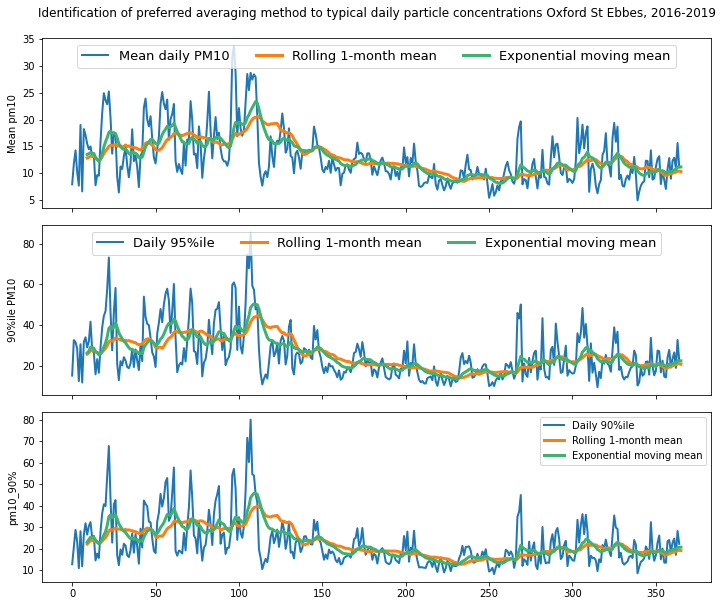

In [15]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

sebbes_lowess_daymean = pd.DataFrame()

# Doing PM10
#------------
figure, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Mean daily PM10', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM10, 90%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Daily 90%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_90%', ax=ax3, label='Exponential moving mean', lw=3, color='mediumseagreen')

ax1.set(xlabel='', ylabel = 'Mean pm10', title='Identification of preferred averaging method to typical daily particle concentrations Oxford St Ebbes, 2016-2019\n')
ax2.set(ylabel = '90%ile PM10')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('identifying_averging_methods.png')

plt.show()

#sebbes_lowess_daymean.reset_index().to_feather(stats_home+'sebbes_lowess_daymean.ftr')


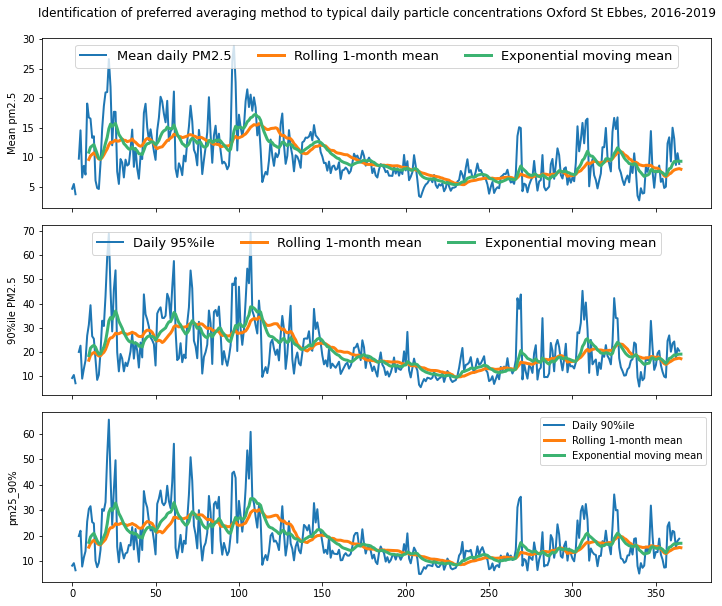

In [16]:
# Compare approaches to calculating mean dailt PM2.5 values by ordinal day
#-------------------------------------------------------------------------

sebbes_lowess_daymean = pd.DataFrame()

# Doing PM2.5
#------------
figure, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax1, label='Mean daily PM2.5', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax1, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_mean', ax=ax1, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM2.5, 95%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_95%', ax=ax2, label='Daily 95%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_95%', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_95%', ax=ax2, label='Exponential moving mean', lw=3, color='mediumseagreen')

# Doing PM2.5, 90%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm25_90%', ax=ax3, label='Daily 90%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_90%', ax=ax3, label='Rolling 1-month mean', lw=3, color='tab:orange')
sns.lineplot(data=sebbes_ordinal_daymean.ewm(alpha=0.1, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm25_90%', ax=ax3, label='Exponential moving mean', lw=3, color='mediumseagreen')

ax1.set(xlabel='', ylabel = 'Mean pm2.5', title='Identification of preferred averaging method to typical daily particle concentrations Oxford St Ebbes, 2016-2019\n')
ax2.set(ylabel = '90%ile PM2.5')

ax1.legend(ncol=3, loc='upper center', fontsize=13)
ax2.legend(ncol=3, loc='upper center', fontsize=13)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('identifying_averging_methods.png')

plt.show()

#sebbes_lowess_daymean.reset_index().to_feather(stats_home+'sebbes_lowess_daymean.ftr')


In [17]:
sebbes_ordinal_daymean

,date,pm25_count,pm25_mean,pm25_std,pm25_min,pm25_50%,pm25_90%,pm25_95%,pm25_max,pm10_count,pm10_mean,pm10_std,pm10_min,pm10_50%,pm10_90%,pm10_95%,pm10_max,y10,ypm1095,ypm1090
0,1,47.0,4.642553,2.464949,0.5,4.4000,8.3000,9.2200,10.000,48.0,7.918750,3.466782,1.4,7.1500,12.7100,15.41500,16.000,12.845797,28.314710,23.791236
1,2,42.0,5.450000,3.815389,-2.9,4.8500,9.2800,10.4650,17.100,48.0,11.727083,8.469890,0.0,9.3500,20.8800,32.76000,39.000,12.929446,28.413213,23.955444
2,3,12.0,3.708333,2.325143,0.1,3.2000,6.4900,7.0400,7.700,36.0,14.255556,10.552060,0.5,12.5000,28.7000,31.82500,34.300,13.009806,28.503877,24.110961
3,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,10.217391,8.269915,1.5,6.4000,23.3200,28.59000,29.300,13.086911,28.586416,24.257727
4,5,11.0,9.736364,7.576975,1.1,6.0000,19.9000,20.0000,20.100,12.0,7.666667,3.576523,3.3,7.4000,10.8500,12.70000,14.900,13.160791,28.660386,24.395577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,54.0,13.098630,6.715243,0.1,11.1000,21.5500,24.3350,34.800,72.0,12.872569,7.567904,2.7,10.0000,24.6700,26.73500,30.000,11.347914,23.122621,21.295809
362,363,68.0,8.667926,4.658593,-0.9,9.0135,15.4907,17.5237,18.600,72.0,10.955903,4.905644,1.1,11.2875,17.0975,19.17125,24.500,11.431732,23.322980,21.509815
363,364,70.0,10.663543,5.930981,-0.7,10.9600,18.0166,21.5750,32.300,72.0,15.638542,9.097126,1.0,13.5125,28.1900,32.86000,36.500,11.516684,23.525749,21.726115
364,365,69.0,8.852420,7.028753,-1.0,7.5000,18.8352,20.4906,26.651,72.0,11.084722,7.209489,-0.4,9.8750,22.1950,22.63375,28.975,11.602785,23.730958,21.944725


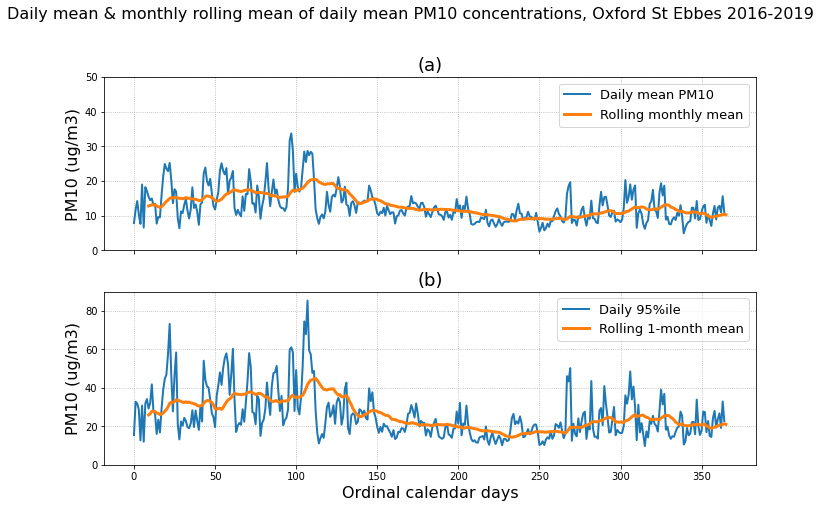

In [18]:
# Compare approaches to calculating mean dailt PM10 values by ordinal day
#-------------------------------------------------------------------------

#sebbes_lowess_daymean = pd.DataFrame()

# Doing PM10
#------------
figure, (ax1, ax2) = plt.subplots(2, figsize=(10,7), sharex=True)

sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Daily mean PM10', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_mean', ax=ax1, label='Rolling monthly mean', lw=3, color='tab:orange')

# Doing PM10, 95%ile
#--------------------
sns.lineplot(data=sebbes_ordinal_daymean, x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Daily 95%ile', lw=2)
sns.lineplot(data=sebbes_ordinal_daymean.rolling(28, min_periods=10).mean(), x=sebbes_ordinal_daymean.index, y='pm10_95%', ax=ax2, label='Rolling 1-month mean', lw=3, color='tab:orange')
plt.rcParams.update({'font.size': 14})

ax1.set_title('(a)', fontsize=18)
ax2.set_title('(b)', fontsize=18)
ax1.set_ylabel('PM10 (ug/m3)', fontsize=16)
ax2.set_ylabel('PM10 (ug/m3)', fontsize=16)
ax2.set_xlabel('Ordinal calendar days', fontsize=16)
ax2.set_title('(b)', fontsize=18)

plt.suptitle('Daily mean & monthly rolling mean of daily mean PM10 concentrations, Oxford St Ebbes 2016-2019', y=1.01, fontsize=16)
#plt.rcParams.update({'font.size': 14})
ax1.legend(ncol=1, loc='upper right',fontsize=13)
ax2.legend(ncol=1, loc='upper right', fontsize=13)
ax1.set_ylim(0,50)
ax2.set_ylim(0,90)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
#plt.rcParams.update({'font.size': 17})
ax1.grid(True, ls=':')
ax2.grid(True, ls=':')

plt.savefig('pm10_pm25_24hr_1mrm_201619.png')

plt.show()

